## Seasonal cash price received GE 500 LB

- Purpose if this notebook is to deep dive into seasonality in the cash price and test how predictible this is

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import src

import warnings
warnings.filterwarnings('ignore')

In [28]:
price_received_ge_500_national = pd.read_csv('../csv/price_received_ge_500_national.csv')

price_received_ge_500_national = src.usda_clean_monthly(price_received_ge_500_national)

price_received_ge_500_national_pct_chg = price_received_ge_500_national.pct_change()*100
price_received_ge_500_national_pct_chg.name = 'price_received_ge_500_national_pct_chg'

price_received_ge_500_national_pct_chg.dropna(inplace=True)

adj_price_received_ge_500_national = src.adjust_series_cpi(price_received_ge_500_national)
adj_price_received_ge_500_national.name = 'adj_price_received_ge_500_national'

- Note, Live Cattle Futures contract tracks the 'Price Received GE 500 LB' very closely
    - Regressing these two variables gives coefficeint of ~1, with p-value ~0, and R-squared ~99.8%. See this [notebook](../futures_cash_price_analysis.ipynb).

In [29]:
df_adj = pd.DataFrame({
    'adj_price_received_ge_500_national':adj_price_received_ge_500_national,
    'month' : adj_price_received_ge_500_national.index.month,
    'quarter' : adj_price_received_ge_500_national.index.quarter,
})



In [30]:
import plotly.subplots as sp

fig = sp.make_subplots(rows=1, cols=1)

fig.add_box(y=df_adj['adj_price_received_ge_500_national'], x=df_adj['month'], name='Price Received')

fig.update_layout(title='Price Received for GE 500 by Month (Adj. CPI)',
                  xaxis_title='Month',
                  yaxis_title='Adjusted Price Received')

fig.show()

Text(0.5, 1.0, 'Mean Price Received for GE 500 National Futures by Month $/cwt (Adj. CPI)')

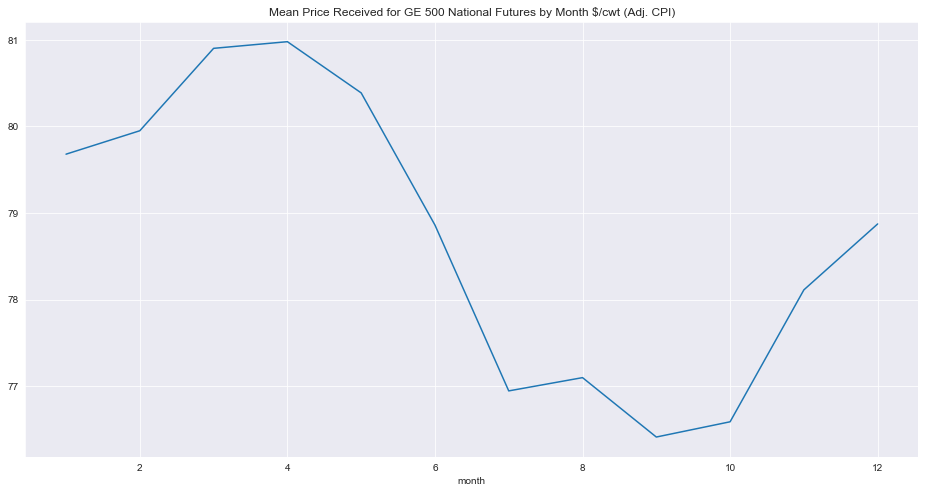

In [31]:
df_adj.groupby('month')['adj_price_received_ge_500_national'].mean().plot()
plt.title('Mean Price Received for GE 500 National Futures by Month $/cwt (Adj. CPI)')

- Cash price received is greater in first half of the year, with maximum in May, and lower during second half of the year, min at October
- Price variance is also higher during first half of the year compared to second half

#### Regressing monthly % change in price with lag of one month

In [32]:
import statsmodels.api as sm


price_received_ge_500_national_pct_chg = price_received_ge_500_national.pct_change()*100

X = price_received_ge_500_national_pct_chg.shift(1).dropna()
X.name = 'price_received_ge_500_national_pct_chg_lag_1'
X = sm.add_constant(X)

y = price_received_ge_500_national_pct_chg[X.index]

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     39.87
Date:                Sun, 10 Sep 2023   Prob (F-statistic):           1.07e-09
Time:                        11:47:03   Log-Likelihood:                -719.53
No. Observations:                 280   AIC:                             1443.
Df Residuals:                     278   BIC:                             1450.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

- Since we are not adjusting for inflation, we expected a positive constant
    - I had tested regressing with CPI adjusted data --> constant is still positive, but half the magnitude and T-value increases

#### Regressing monthly % change in price with lag of 12 months

In [33]:
import statsmodels.api as sm
import pandas as pd

lags = 12
for i in range(1, lags+1):
    
    price_received_ge_500_national_pct_chg_lag = price_received_ge_500_national.pct_change().shift(i)*100
    price_received_ge_500_national_pct_chg_lag.name = f'price_received_ge_500_national_pct_chg_lag_{i}'

    if i == 1:
        X = price_received_ge_500_national_pct_chg_lag.dropna()
    else:
        X = pd.concat([X, price_received_ge_500_national_pct_chg_lag], axis=1)

In [34]:
X = X.dropna()
X = sm.add_constant(X)

y = price_received_ge_500_national_pct_chg[X.index]

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     5.849
Date:                Sun, 10 Sep 2023   Prob (F-statistic):           5.84e-09
Time:                        11:47:03   Log-Likelihood:                -678.84
No. Observations:                 269   AIC:                             1384.
Df Residuals:                     256   BIC:                             1430.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

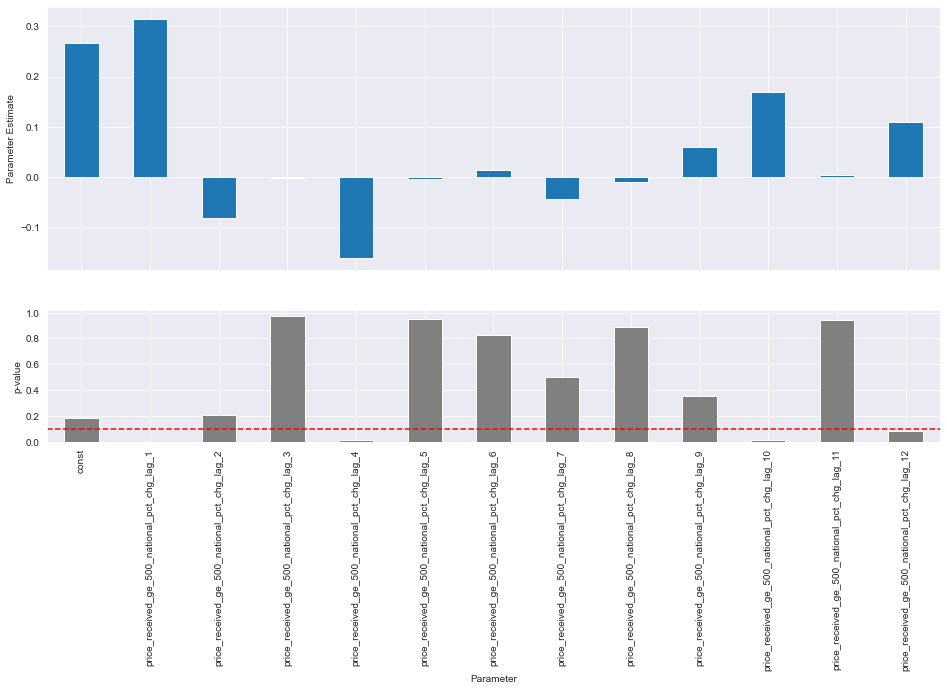

In [35]:
src.plot_coefficients_pvalues(model)

#### Regressing monthly % change in price with dummy for each month

In [43]:
X = pd.get_dummies(df.month)
X.columns = [ f'month_{i}' for i in X.columns]
# X = sm.add_constant(X)

y = price_received_ge_500_national_pct_chg
y = y.dropna()
y.name = 'price_received_ge_500_national_pct_chg'

model = sm.OLS(y, X.loc[y.index, :]).fit()

print(model.summary())

                                      OLS Regression Results                                      
Dep. Variable:     price_received_ge_500_national_pct_chg   R-squared:                       0.110
Model:                                                OLS   Adj. R-squared:                  0.074
Method:                                     Least Squares   F-statistic:                     3.030
Date:                                    Sun, 10 Sep 2023   Prob (F-statistic):           0.000779
Time:                                            11:48:35   Log-Likelihood:                -724.02
No. Observations:                                     281   AIC:                             1472.
Df Residuals:                                         269   BIC:                             1516.
Df Model:                                              11                                         
Covariance Type:                                nonrobust                                         
          

- R-squared not that high, therefore a large part of the variation of the % ∆ in price is not explained by month
- 

Text(0.5, 1.0, 'Mean Price Received for GE 500 National Futures by Month $/cwt (Adj. CPI)')

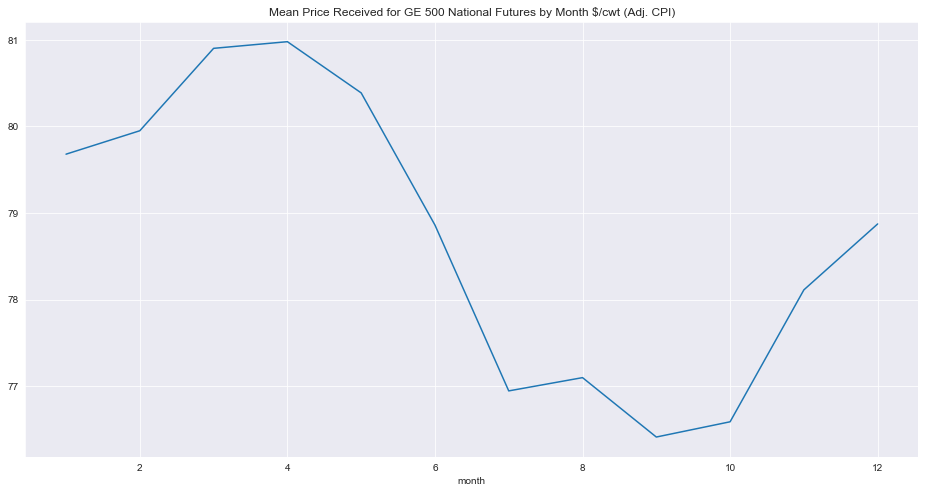

In [44]:
df_adj.groupby('month')['adj_price_received_ge_500_national'].mean().plot()
plt.title('Mean Price Received for GE 500 National Futures by Month $/cwt (Adj. CPI)')

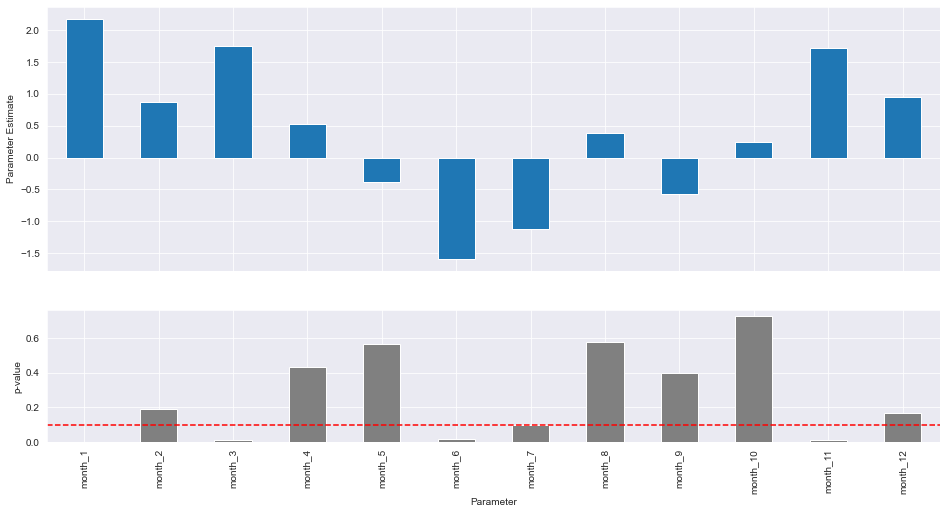

In [45]:
src.plot_coefficients_pvalues(model)

- Price appreciation generally occuring from November to April, with sharpest increase in January
- June is expected to experience sharpest drop in price (-1.5%)

### Lags and Dummies

In [39]:
import statsmodels.api as sm
import pandas as pd

lags = 12

for i in range(1, lags+1):
    
    price_received_ge_500_national_pct_chg_lag = price_received_ge_500_national.pct_change().shift(i)*100
    price_received_ge_500_national_pct_chg_lag.name = f'price_received_ge_500_national_pct_chg_lag_{i}'

    if i == 1:
        X_lags = price_received_ge_500_national_pct_chg_lag.dropna()
    else:
        X_lags = pd.concat([X_lags, price_received_ge_500_national_pct_chg_lag], axis=1)


In [40]:
X_dummies = pd.get_dummies(df.month)
X_dummies.columns = [ f'month_{i}' for i in X_dummies.columns]

X = pd.concat([X_lags, X_dummies], axis=1)

X = X.dropna()

X = sm.add_constant(X)

y = price_received_ge_500_national_pct_chg[X.index]
y = y.dropna()
y.name = 'price_received_ge_500_national_pct_chg'

model = sm.OLS(y, X.loc[y.index, :]).fit()

print(model.summary())

                                      OLS Regression Results                                      
Dep. Variable:     price_received_ge_500_national_pct_chg   R-squared:                       0.282
Model:                                                OLS   Adj. R-squared:                  0.214
Method:                                     Least Squares   F-statistic:                     4.179
Date:                                    Sun, 10 Sep 2023   Prob (F-statistic):           5.99e-09
Time:                                            11:47:04   Log-Likelihood:                -666.91
No. Observations:                                     269   AIC:                             1382.
Df Residuals:                                         245   BIC:                             1468.
Df Model:                                              23                                         
Covariance Type:                                nonrobust                                         
          

## Testing various models

- Test various models in increasing complexity to determine how well price can be predicted on past price behaviour and seasonality alone
- Testing is done using rolling train test splits, and the average mean absolute error across all predictions made during each test split
- Since we are predicting on a percentage level, mean absolute error tells us how many percentage points our prediction was 'off' in terms of magnitude (e.g. if we predict +3%, but realised is -1% this will contribute 4% to our mean absolute error, which will be an average of such errors)

##### Models Tested
 - Naive model
 - Seasonal Dummy Model (Regression)
 - Seasonal Dummy and Lagged Model (Regression)
 - Facebook Prophet

#### Naive Model

In [113]:
errors_naive = list(price_received_ge_500_national_pct_chg.dropna())

In [114]:
errors_naive

[0.44378698224853963,
 2.7982326951399017,
 2.148997134670494,
 -2.66479663394108,
 -1.4409221902017322,
 -0.8771929824561542,
 -2.507374631268444,
 -1.6641452344931862,
 2.3076923076922995,
 3.9097744360902187,
 3.90738060781477,
 3.899721448467952,
 0.13404825737266535,
 1.7402945113788482,
 -0.7894736842105177,
 -2.3872679045092937,
 0.0,
 -2.4456521739130377,
 -1.6713091922005652,
 -2.2662889518413554,
 -3.6231884057971064,
 -3.759398496240607,
 1.0937500000000044,
 4.173106646058744,
 3.857566765578624,
 0.8571428571428452,
 -4.674220963172804,
 -3.268945022288261,
 -1.6897081413210335,
 -0.46874999999999556,
 1.098901098901095,
 0.15527950310558758,
 0.15503875968991832,
 4.179566563467496,
 4.606240713224374,
 3.5511363636363535,
 1.3717421124828544,
 -1.7591339648173387,
 2.6170798898071723,
 1.342281879194629,
 -0.7947019867549643,
 1.2016021361815676,
 4.617414248021112,
 7.061790668348067,
 7.773851590105996,
 2.0765027322404483,
 -3.2119914346895095,
 -10.287610619469035,
 

#### Seasonal Dummy Model (Regression)

In [109]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error



X = pd.get_dummies(price_received_ge_500_national_pct_chg.index.month)
X.index = price_received_ge_500_national_pct_chg.index
X.columns = [ f'month_{i}' for i in X.columns]

y = price_received_ge_500_national_pct_chg
y = y.dropna()
y.name = 'price_received_ge_500_national_pct_chg'

df_seasonal = pd.concat([y, X], axis=1)
df_seasonal = df_seasonal.dropna()
df_seasonal

tscv = TimeSeriesSplit(n_splits=5, test_size=int(len(df_seasonal)/10))




In [110]:
errors_seasonal = []
errors_seasonal_directional = []

for train_index, test_index in tscv.split(df_seasonal):

    train_data, test_data = df_seasonal.iloc[train_index], df_seasonal.iloc[test_index]

    model = sm.OLS(train_data['price_received_ge_500_national_pct_chg'],
        train_data.drop('price_received_ge_500_national_pct_chg', axis=1)
    ).fit()

    y_pred = model.predict(test_data.drop('price_received_ge_500_national_pct_chg', axis=1))

    errors_seasonal.extend(test_data['price_received_ge_500_national_pct_chg'] - y_pred)
    
    errors_seasonal_directional.extend(
        [1 if i > 0 else 0 for i in test_data['price_received_ge_500_national_pct_chg']*y_pred]
    )
        
        


In [105]:
len(errors_seasonal)

140

<AxesSubplot:>

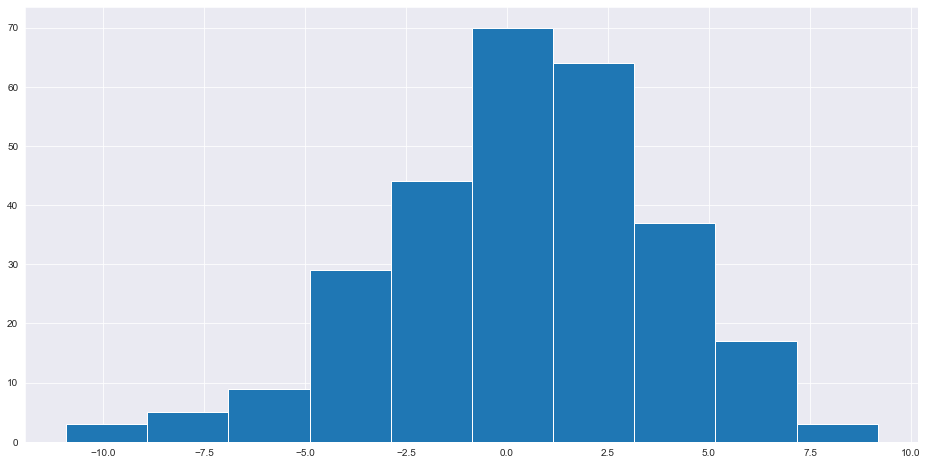

In [92]:
pd.Series(errors_naive).hist()

In [115]:
print(f'Mean absolute error of  model: {round(np.mean(abs(pd.Series(errors_naive))),2)} %')

Mean absolute error of AR(1) model: 2.67 %


<AxesSubplot:>

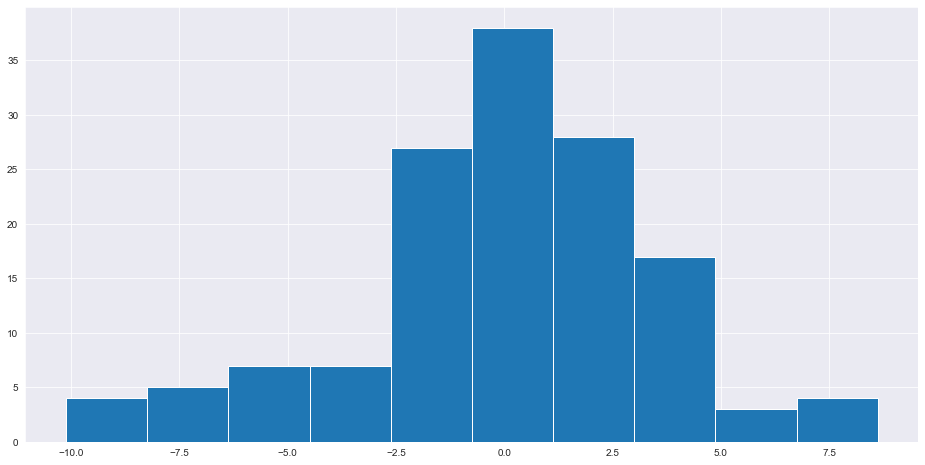

In [107]:
pd.Series(errors_seasonal).hist()

In [108]:
np.mean(abs(pd.Series(errors_seasonal)))

2.5986839848451706

In [111]:
import numpy as np

np.mean([1 if i > 0 else 0 for i in price_received_ge_500_national_pct_chg])

0.5673758865248227

In [112]:
np.mean(errors_seasonal_directional)

0.55

In [ ]:
import numpy as np

print(f'Correct directional forecast: {np.mean([1 if i > 0 else 0 for i in errors_seasonal])*100:.2f}%')

In [49]:
X = pd.get_dummies(df.month)
X.columns = [ f'month_{i}' for i in X.columns]
# X = sm.add_constant(X)

y = price_received_ge_500_national_pct_chg
y = y.dropna()
y.name = 'price_received_ge_500_national_pct_chg'

model = sm.OLS(y, X.loc[y.index, :]).fit()

print(model.summary())

                                      OLS Regression Results                                      
Dep. Variable:     price_received_ge_500_national_pct_chg   R-squared:                       0.110
Model:                                                OLS   Adj. R-squared:                  0.074
Method:                                     Least Squares   F-statistic:                     3.030
Date:                                    Sun, 10 Sep 2023   Prob (F-statistic):           0.000779
Time:                                            12:46:27   Log-Likelihood:                -724.02
No. Observations:                                     281   AIC:                             1472.
Df Residuals:                                         269   BIC:                             1516.
Df Model:                                              11                                         
Covariance Type:                                nonrobust                                         
          